In [1]:
import numpy as np
import torch

# Data parameters
data_root = "./data/"
data_path = "nucleon_41x41x41_uint8.raw"
data_shape = (41, 41, 41)
data_type = np.uint8

# Fiting parameters
batch_size = 1024
num_workers = 3
num_epochs = 10
lr = 0.008
device = torch.device("cpu")  # or "cuda" for GPU
dtype = torch.float32

In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
from volumetric_dataset import VolumetricDataset

# Create dataset and dataloader
dataset = VolumetricDataset(
    Path(data_root, data_path),
    data_shape,
    data_type,
    normalize_coords=True,
    normalize_values=True,
)
loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=num_workers)

In [3]:
# from networks import INR_Base

# Create model
# kan_inr = INR_Base(
#     n_input_dims=3,
#     n_output_dims=1,
#     network="F-KAN",
#     n_hidden_layers=3,
#     n_neurons=64,
#     activation="SiLU",  # Base activation
# )
from networks import FKAN_Native

kan_inr = FKAN_Native(
    n_input_dims=3,
    n_output_dims=1,
    n_hidden_layers=3,
    n_neurons=64,
    activation="SiLU",  # Base activation
)
kan_inr

FKAN_Native(
  (fkan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=24, out_features=64, bias=False)
        (base_linear): Linear(in_features=3, out_features=64, bias=True)
      )
      (1-2): 2 x FastKANLayer(
        (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=512, out_features=64, bias=False)
        (base_linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): FastKANLayer(
        (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=512, out_features=1, bias=False)
        (base_linear): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)

In [4]:
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm


kan_inr.to(device, dtype)
optimizer = AdamW(kan_inr.parameters(), lr=lr)
loss_fn = nn.functional.mse_loss
loader.dataset.return_indices = False

# Training loop
epoch_losses = []
for epoch in range(num_epochs):
    loss_total = 0.0
    for x, y_hat in tqdm(loader):
        x = x.to(device, dtype)
        y_hat = y_hat.to(device, dtype)
        y = kan_inr(x)
        loss = loss_fn(y, y_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    avg_loss = loss_total / len(loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

100%|██████████| 68/68 [00:03<00:00, 19.50it/s]


Epoch 1/10, Loss: 0.164501


100%|██████████| 68/68 [00:02<00:00, 25.22it/s]


Epoch 2/10, Loss: 0.005943


100%|██████████| 68/68 [00:02<00:00, 28.47it/s]


Epoch 3/10, Loss: 0.003735


100%|██████████| 68/68 [00:02<00:00, 28.36it/s]


Epoch 4/10, Loss: 0.003420


100%|██████████| 68/68 [00:02<00:00, 30.38it/s]


Epoch 5/10, Loss: 0.003151


100%|██████████| 68/68 [00:02<00:00, 25.24it/s]


Epoch 6/10, Loss: 0.002179


100%|██████████| 68/68 [00:02<00:00, 25.89it/s]


Epoch 7/10, Loss: 0.002175


100%|██████████| 68/68 [00:02<00:00, 27.81it/s]


Epoch 8/10, Loss: 0.002881


100%|██████████| 68/68 [00:02<00:00, 26.27it/s]


Epoch 9/10, Loss: 0.001414


100%|██████████| 68/68 [00:02<00:00, 24.29it/s]

Epoch 10/10, Loss: 0.001385


In [7]:
from pprint import pprint
pprint(kan_inr.state_dict().keys())

odict_keys(['fkan.layers.0.layernorm.weight', 'fkan.layers.0.layernorm.bias', 'fkan.layers.0.rbf.grid', 'fkan.layers.0.spline_linear.weight', 'fkan.layers.0.base_linear.weight', 'fkan.layers.0.base_linear.bias', 'fkan.layers.1.layernorm.weight', 'fkan.layers.1.layernorm.bias', 'fkan.layers.1.rbf.grid', 'fkan.layers.1.spline_linear.weight', 'fkan.layers.1.base_linear.weight', 'fkan.layers.1.base_linear.bias', 'fkan.layers.2.layernorm.weight', 'fkan.layers.2.layernorm.bias', 'fkan.layers.2.rbf.grid', 'fkan.layers.2.spline_linear.weight', 'fkan.layers.2.base_linear.weight', 'fkan.layers.2.base_linear.bias', 'fkan.layers.3.layernorm.weight', 'fkan.layers.3.layernorm.bias', 'fkan.layers.3.rbf.grid', 'fkan.layers.3.spline_linear.weight', 'fkan.layers.3.base_linear.weight', 'fkan.layers.3.base_linear.bias'])


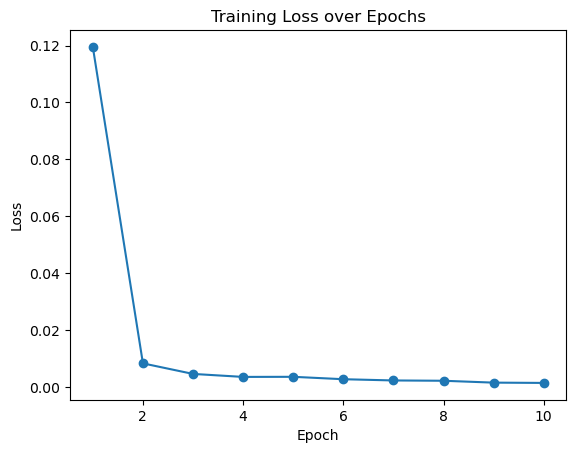

In [5]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure

# Reconstruct the entire volume from the INR
kan_inr.eval()
with torch.no_grad():
    reconst_data = torch.zeros(dataset.data_shape, device=device, dtype=dtype)
    loader.dataset.return_indices = True
    for x, _, (i, j, k) in loader:
        x = x.to(device, dtype)
        y = kan_inr(x)
        for y_s, i_s, j_s, k_s in zip(y, i, j, k):
            reconst_data[i_s.item(), j_s.item(), k_s.item()] = y_s.item()

gt_data = torch.tensor(
    dataset.data.reshape(dataset.data_shape, order="F"), device=device, dtype=dtype
)
reconst_data = torch.clip(reconst_data, 0.0, 1.0)

psnr = peak_signal_noise_ratio(reconst_data, gt_data)
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")
ssim = structural_similarity_index_measure(reconst_data.unsqueeze(0), gt_data.unsqueeze(0))
print(f"Structural Similarity Index (SSIM): {ssim:.4f}")

/grand/insitu/cohanlon/miniconda3/envs/alcf_kan_inr/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/grand/insitu/cohanlon/miniconda3/envs/alcf_kan_inr/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Peak Signal-to-Noise Ratio (PSNR): 29.80 dB
Structural Similarity Index (SSIM): 0.8346


In [ ]:
# NOTE: this doesn't work on Sophia, and has to be set up on local machine
import pyvista as pv

# Visualize ground truth and reconstructed data
gt_grid = pv.ImageData()
gt_grid.dimensions = np.array(dataset.data_shape) + 1
gt_grid.origin = (0, 0, 0)
gt_grid.spacing = (1, 1, 1)
gt_grid.cell_data["values"] = dataset.data.flatten(order="F")
reconst_grid = pv.ImageData()
reconst_grid.dimensions = np.array(dataset.data_shape) + 1
reconst_grid.origin = (0, 0, 0)
reconst_grid.spacing = (1, 1, 1)
reconst_grid.cell_data["values"] = reconst_data.flatten(order="F")
p = pv.Plotter(shape=(1, 2))
# p.add_mesh(gt_grid.contour(), scalars="values")
p.subplot(0, 1)
# p.add_mesh(reconst_grid.contour(), scalars="values")
p.show()()